# Adaptive PDE discretizations on cartesian grids 
## Volume : GPU accelerated methods
## Part : Reproducibility
## Chapter : Curvature penalized models

In this notebook, we run some TTI models (Tilted Transversely Anisotropic), a kind of Finslerian manifold appearing in seismology, on the CPU and GPU, and check that they produce consistent results.

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"../..")
#from Miscellaneous import TocTools; print(TocTools.displayTOC('Rander_Repro','GPU'))

In [2]:
import cupy as cp
import numpy as np
import itertools
from matplotlib import pyplot as plt
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%5.3g" % x))

In [3]:
from agd import HFMUtils
from agd import AutomaticDifferentiation as ad
from agd import Metrics
from agd import FiniteDifferences as fd
from agd import LinearParallel as lp
from agd.Metrics.Seismic import Reduced
import agd.AutomaticDifferentiation.cupy_generic as cugen

norm_infinity = ad.Optimization.norm_infinity
from Notebooks_GPU.ExportedCode.Isotropic_Repro import RunCompare

In [4]:
def ReloadPackages():
    from Miscellaneous.rreload import rreload
    global HFMUtils,ad,cugen,Metrics,Reduced
    HFMUtils,ad,cugen,Metrics,Reduced = rreload([HFMUtils,ad,cugen,Metrics,Reduced],"../..")    
    HFMUtils.dictIn.RunSmart = cugen.cupy_get_args(HFMUtils.RunSmart,dtype64=True,iterables=(dict,Metrics.Base))

In [5]:
cp = ad.functional.decorate_module_functions(cp,cugen.set_output_dtype32) # Use float32 and int32 types in place of float64 and int64
plt = ad.functional.decorate_module_functions(plt,cugen.cupy_get_args)
HFMUtils.dictIn.RunSmart = cugen.cupy_get_args(HFMUtils.RunSmart,dtype64=True,iterables=(dict,Metrics.Base))

# 1. Two dimensions

In [267]:
ReloadPackages()

### 1.1 Defining a seismic norm, and calling the gpu code

In [7]:
n=1000
hfmIn = HFMUtils.dictIn({
    'model':'TTI2',
    'arrayOrdering':'RowMajor',
    'exportValues':1,
    'seeds':cp.array([[0.,0.]]),
    'factoringRadius':20,
    'count_updates':True,
})

hfmIn.SetRect(sides=[[-1,1],[-1,1]],dimx=n+1,sampleBoundary=True) # Define the domain
X = hfmIn.Grid() # Horizontal and vertical axis

lin = cp.array([1.,2.])
#quad = xp.zeros((2,2))
quad = cp.array([[0.,0.2],[0.2,0.]])
#quad = xp.array([[0.5,0.1],[0.1,-0.2]])
metric = Reduced(lin,quad).rotate_by(cp.array(0.5)) #Linear and quadratic part
hfmIn['metric'] = metric

Casting output of function array from float64 to float32
Casting output of function array from float64 to float32
Casting output of function array from float64 to float32
Casting output of function array from float64 to float32


We are here defining a constant norm over the domain, hence the exact solution can be computed directly for reference.

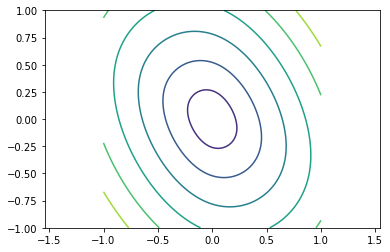

In [8]:
plt.axis('equal')
plt.contour(*X,metric.norm(X))

In [9]:
hfmOut = hfmIn.RunGPU()

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.931016206741333 seconds, and 160 iterations.
Post-Processing


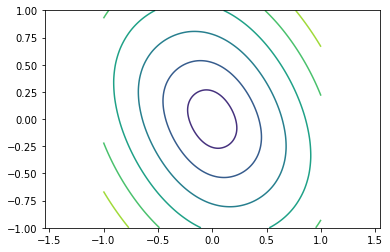

In [10]:
plt.axis('equal')
plt.contour(*X,hfmOut['values']);

### 1.2 The Riemannian approximation

In [12]:
riemIn = hfmIn.copy()
riemIn['model'] = 'Riemann2'
riemIn['metric'] = Metrics.Riemann.from_diagonal(1/lin).rotate_by(cp.array(0.5))
riemOut = riemIn.RunGPU()

Casting output of function array from float64 to float32
Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.09747552871704102 seconds, and 149 iterations.
Post-Processing


The CPU time for the TTI model is, on large instances, typically 30 times the one of the Riemannian model. This exceeds the expected scaling of $10 \times$ due to the fact that the TTI norm is expressed as an extremum of 10 riemannian norms. (Some investigation is needed.)

The number of block updates is similar.

In [13]:
np.mean(hfmOut['stats']['eikonal']['nupdate_o']),np.mean(riemOut['stats']['eikonal']['nupdate_o'])

(array( 20.1), array( 16.9))

The Riemannian approximation is not very far, yet the distinct shape of the level sets is clearly visible.

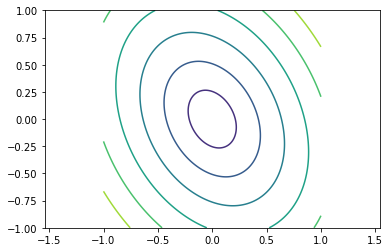

In [14]:
plt.axis('equal')
plt.contour(*X,riemOut['values'])

### 1.3 Comparison with the CPU code

The CPU code implements the operator in a different manner, using a Newton method rather than an exhaustive search to find the optimal ellipse. It agrees quite well with the GPU code, at second order w.r.t. the number of ellipses used.

In [15]:
gpuOut,cpuOut = RunCompare(hfmIn,check=1e-3)

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.8544955253601074 seconds, and 160 iterations.
Post-Processing
--- gpu done, turning to cpu ---
Field verbosity defaults to 1
Field order defaults to 1
Field seedRadius defaults to 2
Fast marching solver completed in 13.825 s.
***** Warning ! *****
Unused fields from user: count_updates 
********************
Solver time (s). GPU : 0.8544955253601074, CPU : 14.998. Device acceleration : 17.55187658083925
Max |gpuValues-cpuValues| :  0.0005596334403690228


The number of ellipses used in the envelope of the TTI norm is defined as the following trait.
The GPU code can be accelerated by reducing it, at the possible expense of accuracy.

In [16]:
gpuOut['keys']['default']['traits']['nmix']

7

In [18]:
hfmIn5 = hfmIn.copy(); hfmIn5['traits'] = hfmIn5.get('traits',{}).copy()
hfmIn5['traits']['nmix'] = 5 # Use 5 ellipses for the envelope

In [19]:
gpuOut5 = hfmIn5.RunGPU()
np.max(np.abs(gpuOut5['values'].get() - cpuOut['values']))

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.5934743881225586 seconds, and 160 iterations.
Post-Processing


0.0011797716291963578

## 2. Three dimensions

In [20]:
n=10
hfmIn = HFMUtils.dictIn({
    'model':'TTI3',
    'exportValues':1,
    'seeds':cp.array([[0.,0.,0.]]),
    'factoringRadius':20,
    'seedRadius':2,
    'order':2
})

hfmIn.SetRect(sides=[[-1,1],[-1,1],[-1,1] ],dimx=n+1,sampleBoundary=True) # Define the domain
X = hfmIn.Grid() 

metric = Reduced(lin,quad).to_TTI3().rotate_by(cp.array(0.5),axis=cp.array((1,2,3.)))
hfmIn['metric'] = metric

Casting output of function array from float64 to float32
Casting output of function array from float64 to float32
Casting output of function array from float64 to float32


In [21]:
exact = metric.norm(X)

In [22]:
gpuOut,cpuOut = RunCompare(hfmIn,check=False)

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.04695391654968262 seconds, and 13 iterations.
Post-Processing
--- gpu done, turning to cpu ---
Field verbosity defaults to 1
Fast marching solver completed in 0.197 s.
Solver time (s). GPU : 0.04695391654968262, CPU : 0.201. Device acceleration : 4.280793057748847
Max |gpuValues-cpuValues| :  0.007617029326057123


In [23]:
np.max(np.abs(exact - gpuOut['values']))

array(0.00466, dtype=float32)

In [24]:
np.max(np.abs(exact.get() - cpuOut['values']))

0.006629746510057766

In [25]:
#hfmIn.RunGPU()

In [219]:
metric.flatten(transposed_transformation=True).dtype

dtype('float64')